In [1]:
%config Completer.use_jedi = False

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

sns.set_style('white')

In [4]:
import sys
sys.path.append('..')

from src.configs import config

%load_ext autoreload
%autoreload 2

# 1. MR Data Extraction
---

In [114]:
from xml.etree import cElementTree as ElementTree

class XmlListConfig(list):
    def __init__(self, aList):
        for element in aList:
            if element:
                # treat like dict
                if len(element) == 1 or element[0].tag != element[1].tag:
                    self.append(XmlDictConfig(element))
                # treat like list
                elif element[0].tag == element[1].tag:
                    self.append(XmlListConfig(element))
            elif element.text:
                text = element.text.strip()
                if text:
                    self.append(text)


class XmlDictConfig(dict):
    '''
    Example usage:

    >>> tree = ElementTree.parse('your_file.xml')
    >>> root = tree.getroot()
    >>> xmldict = XmlDictConfig(root)

    Or, if you want to use an XML string:

    >>> root = ElementTree.XML(xml_string)
    >>> xmldict = XmlDictConfig(root)

    And then use xmldict for what it is... a dict.
    '''
    def __init__(self, parent_element):
        if parent_element.items():
            self.update(dict(parent_element.items()))
        for element in parent_element:
            if element:
                # treat like dict - we assume that if the first two tags
                # in a series are different, then they are all different.
                if len(element) == 1 or element[0].tag != element[1].tag:
                    aDict = XmlDictConfig(element)
                # treat like list - we assume that if the first two tags
                # in a series are the same, then the rest are the same.
                else:
                    # here, we put the list in dictionary; the key is the
                    # tag name the list elements all share in common, and
                    # the value is the list itself 
                    aDict = {element[0].tag: XmlListConfig(element)}
                # if the tag has attributes, add those to the dict
                if element.items():
                    aDict.update(dict(element.items()))
                self.update({element.tag: aDict})
            # this assumes that if you've got an attribute in a tag,
            # you won't be having any text. This may or may not be a 
            # good idea -- time will tell. It works for the way we are
            # currently doing XML configuration files...
            elif element.items():
                self.update({element.tag: dict(element.items())})
            # finally, if there are no child tags and no attributes, extract
            # the text
            else:
                self.update({element.tag: element.text})

In [115]:
tree = ElementTree.parse('../data/Anton-20210629_111930.xml')
root = tree.getroot()
xmldict = XmlDictConfig(root)

In [139]:
import re
items = '\n'.join({ i['description'] for i in xmldict[
    '{http://nrg.wustl.edu/catalog}sets'][
    '{http://nrg.wustl.edu/catalog}entrySet'] })

In [145]:
labels = re.findall('label: (.*)\n', items)
labels = pd.DataFrame([ { 'experiment_id': l } for l in labels ])
labels.to_csv(config.PATHS.DATA_ROOT/'OASIS.csv', index=False)
labels.head()

,experiment_id
0,OAS2_0172_MR1
1,OAS2_0171_MR2
2,OAS2_0157_MR2
3,OAS2_0076_MR1
4,OAS2_0127_MR3


# 4. Explorational Data Analisys
---

In [5]:
df = pd.read_csv('data/oasis_longitudinal.csv')
df.head()

,Subject ID,MRI ID,Group,Visit,MR Delay,M/F,Hand,Age,EDUC,SES,MMSE,CDR,eTIV,nWBV,ASF
0,OAS2_0001,OAS2_0001_MR1,Nondemented,1,0,M,R,87,14,2.0,27.0,0.0,1987,0.696,0.883
1,OAS2_0001,OAS2_0001_MR2,Nondemented,2,457,M,R,88,14,2.0,30.0,0.0,2004,0.681,0.876
2,OAS2_0002,OAS2_0002_MR1,Demented,1,0,M,R,75,12,NaN,23.0,0.5,1678,0.736,1.046
3,OAS2_0002,OAS2_0002_MR2,Demented,2,560,M,R,76,12,NaN,28.0,0.5,1738,0.713,1.010
4,OAS2_0002,OAS2_0002_MR3,Demented,3,1895,M,R,80,12,NaN,22.0,0.5,1698,0.701,1.034


In [6]:
df = df.loc[df['Visit']==1] # use first visit data only because of the analysis we're doing
df = df.reset_index(drop=True) # reset index after filtering first visit data
df['M/F'] = df['M/F'].replace(['F','M'], [0,1]) # M/F column
df['Group'] = df['Group'].replace(['Converted'], ['Demented']) # Target variable
df['Group'] = df['Group'].replace(['Demented', 'Nondemented'], [1,0]) # Target variable
df = df.drop(['MRI ID', 'Visit', 'Hand'], axis=1) # Drop unnecessary columns

# MR & PET Exploration 

In [7]:
# !git clone https://github.com/ubamba98/Brain-Segmentation.git
# mv Brain-Segmentation/utils src/util

In [8]:
from utils.losses import *
from utils.preprocess import *
from keras.models import load_model

In [104]:
path = '../data/OASIS/OAS30001_MR_d0129/anat1/NIFTI/sub-OAS30001_ses-d0129_acq-TSE_T2w.nii.gz'
label = 5

In [105]:
path = '../data/OASIS/OAS30001_MR_d0129/anat3/NIFTI/sub-OAS30001_ses-d0129_run-02_T1w.nii.gz'

In [106]:
model = load_model(
    config.PATHS.MODELS/'label{}'.format(label)/'best.h5',
    custom_objects={
        'dice_coefficient': dice_coefficient, 
        'dice_loss':  dice_loss
    })

In [107]:
def infer(model, T1_path, label, FLAIR_path=None, IR_path=None):
    if label in [1,3,5]:
        T1 = get_data_with_skull_scraping(T1_path)
        if label == 5:
            X = np.array((T1>=10) & (T1<110)).astype(np.uint8)[None,None,...]
        elif label == 3:
            X = np.array(T1>=150).astype(np.uint8)[None,None,...]
        else:
            X = np.array((T1>=80) & (T1<160)).astype(np.uint8)[None,None,...]
        y_pred = model.predict(X)
    else:
        T1 = histeq(to_uint8(get_data_with_skull_scraping(T1_path)))[None,None,...]
        IR = IR_to_uint8(get_data(IR_path))[None,None,...]
        FLAIR = to_uint8(get_data(FLAIR_path))[None,None,...]
        y_pred = model.predict([T1,FLAIR,IR])
    return y_pred.squeeze()

In [108]:
T1 = get_data_with_skull_scraping(path)
if label == 5:
    X = np.array((T1>=10) & (T1<110)).astype(np.uint8)[None,None,...]
elif label == 3:
    X = np.array(T1>=150).astype(np.uint8)[None,None,...]
else:
    X = np.array((T1>=80) & (T1<160)).astype(np.uint8)[None,None,...]

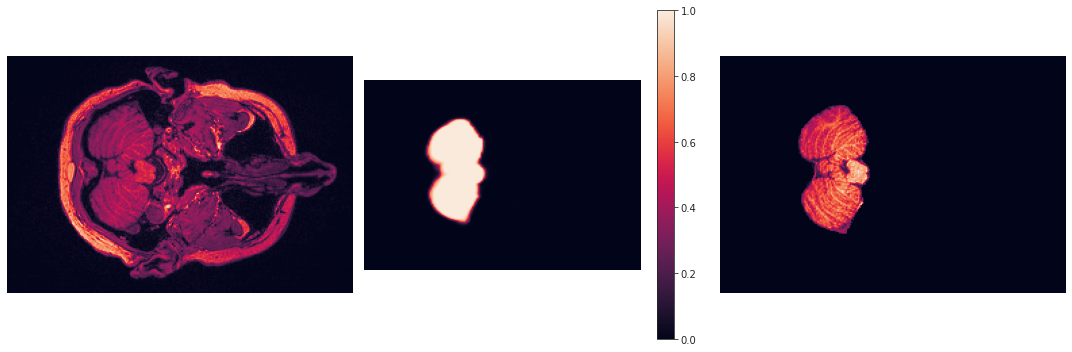

In [111]:
fig, ax = plt.subplots(ncols=3, figsize=(15, 5))
ax[0].imshow(arr[..., 80])
ax[0].axis('off')
cs = ax[1].imshow(prob[..., 80])
plt.colorbar(cs, ax=ax[1])
ax[1].axis('off')
ax[2].imshow(T1[..., 80])
ax[2].axis('off')
plt.tight_layout()
plt.show()

In [219]:
from PIL import Image
import scipy.ndimage

def save_gif(arr, name, cm=plt.get_cmap()):
    ims = list()
    for a in arr.T:
        a = scipy.ndimage.zoom(a, 2.)
        a = (cm(a)[..., :-1] * 255).astype(np.uint8)
        ims.append(Image.fromarray(a))
    plt.imshow(a)

    ims[0].save(
        '{}.gif'.format(name), optimize=False,
        save_all=True, append_images=ims[1:], loop=0)

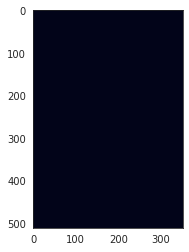

In [220]:
save_gif(arr, 'arr')
save_gif(prob, 'prob')
save_gif(T1, 't1')

In [157]:
import nibabel as nib
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import numpy as np
from skimage import measure

def plot_3d(image, threshold=-300): 
    p = image.transpose(2,1,0)
    verts, faces, normals, values = measure.marching_cubes_lewiner(p, threshold)
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')
    mesh = Poly3DCollection(verts[faces], alpha=0.1)
    face_color = [.1, .6, .5, .5]
    mesh.set_facecolor(face_color)
    ax.add_collection3d(mesh)
    ax.set_xlim(0, p.shape[0])
    ax.set_ylim(0, p.shape[1])
    ax.set_zlim(0, p.shape[2])

    plt.show()

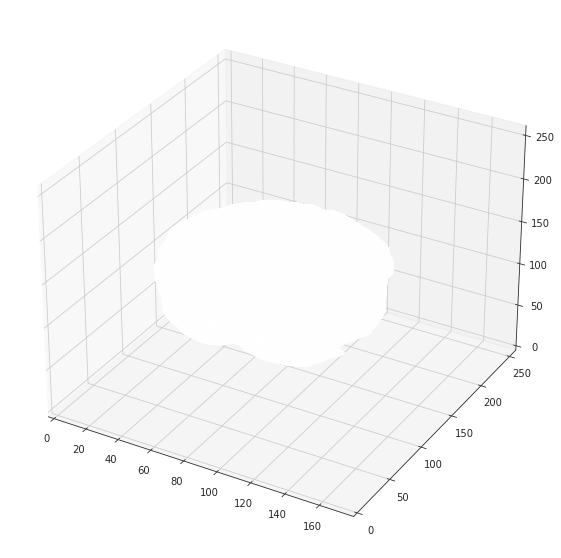

In [158]:
plot_3d(prob.T, threshold=.5)

In [110]:
def t_crop_slice(a, shape=(240, 240, 48)):
    a = a.T
    oa = (a.shape[0] - shape[0]) // 2
    ob = (a.shape[1] - shape[1]) // 2
    return a[oa:-oa, ob:-ob]

In [93]:
T1 = t_crop_slice(T1)

In [94]:
predict = model.predict(T1[np.newaxis, np.newaxis, ..., 60:108])

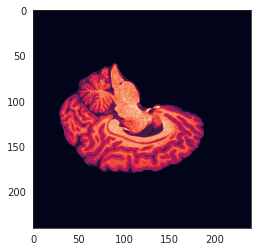

In [100]:
plt.imshow(T1[..., 80])

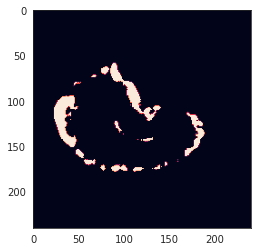

In [99]:
plt.imshow(predict[0, 0, ..., 20])